## CNN 스팸 메일 분류

### 데이터 로드 및 전처리

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

* https://raw.githubusercontent.com/mohitgupta-omg/Kaggle-SMS-Spam-Collection-Dataset-/master/spam.csv

In [3]:
import urllib.request

urllib.request.urlretrieve('https://raw.githubusercontent.com/mohitgupta-omg/Kaggle-SMS-Spam-Collection-Dataset-/master/spam.csv',filename='spam.csv')
data = pd.read_csv('spam.csv',encoding='latin-1')
print(len(data))

5572


In [4]:
data[:10]

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN
5,spam,FreeMsg Hey there darling it's been 3 week's n...,NaN,NaN,NaN
6,ham,Even my brother is not like to speak with me. ...,NaN,NaN,NaN
7,ham,As per your request 'Melle Melle (Oru Minnamin...,NaN,NaN,NaN
8,spam,WINNER!! As a valued network customer you have...,NaN,NaN,NaN
9,spam,Had your mobile 11 months or more? U R entitle...,NaN,NaN,NaN


In [5]:
del data['Unnamed: 2']
del data['Unnamed: 3']
del data['Unnamed: 4']
data['v1'] = data['v1'].replace(['ham','spam'], [0,1])
data[:10]

,v1,v2
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."
5,1,FreeMsg Hey there darling it's been 3 week's n...
6,0,Even my brother is not like to speak with me. ...
7,0,As per your request 'Melle Melle (Oru Minnamin...
8,1,WINNER!! As a valued network customer you have...
9,1,Had your mobile 11 months or more? U R entitle...


In [6]:
data.drop_duplicates(subset=['v2'],inplace=True)
len(data)

5169

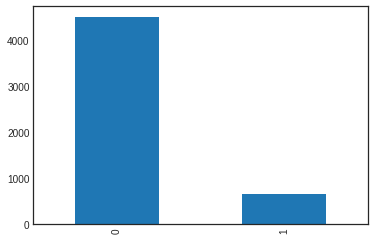

In [11]:
data['v1'].value_counts().plot(kind='bar');

In [12]:
data.groupby('v1').size().reset_index(name='count')

,v1,count
0,0,4516
1,1,653


In [13]:
X_data = data['v2']
y_data = data['v1']

In [14]:
vocab_size = 1000
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(X_data)
sequences = tokenizer.texts_to_sequences(X_data)

In [15]:
sequences[:2]

[[47, 433, 780, 705, 662, 64, 8, 94, 121, 434, 142, 68, 57, 137],
 [49, 306, 435, 6]]

In [18]:
X_data = sequences

print('메일 최대 길이: {}'.format(max(len(l) for l in X_data)))
print('메일 평균 길이: {}'.format((sum(map(len, X_data))/ len(X_data))))

메일 최대 길이: 172
메일 평균 길이: 12.566840781582512


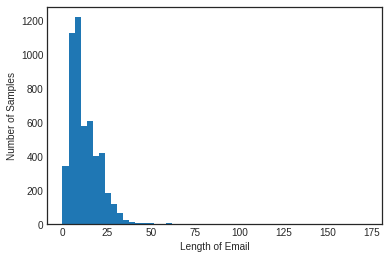

In [19]:
plt.hist([len(s) for s in X_data], bins=50)
plt.xlabel('Length of Email')
plt.ylabel('Number of Samples')
plt.show()

In [20]:
max_len = 60
data = pad_sequences(X_data, maxlen=max_len)
print(data.shape)

(5169, 60)


In [21]:
n_train = int(len(sequences) * 0.8)
n_test = int(len(sequences) - n_train)
print(n_train)
print(n_test)

4135
1034


In [22]:
X_train = data[:n_train]
y_train = np.array(y_data[:n_train])
X_test = data[n_train:]
y_test = np.array(y_data[n_train:])

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(4135, 60)
(4135,)
(1034, 60)
(1034,)


### 모델 구성

In [23]:
from tensorflow.keras.layers import Dense, Conv1D, GlobalMaxPooling1D, Embedding, Dropout, MaxPool1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [24]:
model = Sequential()
model.add(Embedding(vocab_size, 32))
model.add(Dropout(0.2))
model.add(Conv1D(32,5, strides=1, padding='valid', activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.summary()

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['acc'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 32)          32000     
_________________________________________________________________
dropout (Dropout)            (None, None, 32)          0         
_________________________________________________________________
conv1d (Conv1D)              (None, None, 32)          5152      
_________________________________________________________________
global_max_pooling1d (Global (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 64)                2112      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 6

In [25]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc',mode='max',verbos=1,save_best_only=True)

### 모델 학습

In [27]:
history = model.fit(X_train,y_train,
                    batch_size=64,
                    epochs=10,
                    validation_split=0.2,
                    callbacks=[es,mc])

Epoch 1/10
52/52 [==============================] - 0s 9ms/step - loss: 0.4727 - acc: 0.8649 - val_loss: 0.3850 - val_acc: 0.8730
Epoch 2/10
52/52 [==============================] - 0s 5ms/step - loss: 0.3729 - acc: 0.8697 - val_loss: 0.3380 - val_acc: 0.8730
Epoch 3/10
52/52 [==============================] - 0s 5ms/step - loss: 0.2403 - acc: 0.8933 - val_loss: 0.1220 - val_acc: 0.9734
Epoch 4/10
52/52 [==============================] - 0s 6ms/step - loss: 0.0746 - acc: 0.9828 - val_loss: 0.0579 - val_acc: 0.9794
Epoch 5/10
52/52 [==============================] - 0s 5ms/step - loss: 0.0383 - acc: 0.9903 - val_loss: 0.0495 - val_acc: 0.9807
Epoch 6/10
52/52 [==============================] - 0s 5ms/step - loss: 0.0261 - acc: 0.9918 - val_loss: 0.0489 - val_acc: 0.9782
Epoch 7/10
52/52 [==============================] - 0s 5ms/step - loss: 0.0170 - acc: 0.9958 - val_loss: 0.0497 - val_acc: 0.9794
Epoch 8/10
52/52 [==============================] - 0s 5ms/step - loss: 0.0118 - acc: 0.99

### 시각화

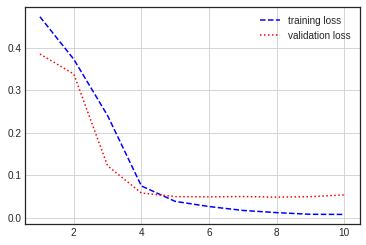

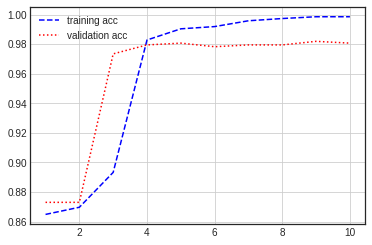

In [29]:
loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['acc']
val_acc = history.history['val_acc']

epochs = range(1,len(loss)+1)
plt.plot(epochs, loss, 'b--', label='training loss')
plt.plot(epochs, val_loss, 'r:', label='validation loss')
plt.grid()
plt.legend()

plt.figure()
plt.plot(epochs, acc, 'b--', label='training acc')
plt.plot(epochs, val_acc, 'r:', label='validation acc')
plt.grid()
plt.legend()
plt.show()

In [30]:
model.evaluate(X_test, y_test)

33/33 [==============================] - 0s 2ms/step - loss: 0.0641 - acc: 0.9836


[0.06406201422214508, 0.9835590124130249]